Work plan:
+ delete `car_ID`, shorten 'carname' to car brands, add + 3 to `symboling` to remove negative values;
+ take the logarithm `price`, reduce the asymmetry in numeric variables using `boxcox`;
+ split categorical features using `pd.get_dummies`;
+ scaling numeric variables using `StandardScaler()`;
+ train our model on default settings, using cross-validation for `train` in parallel.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, skew
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy.special import boxcox

from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-price-prediction/CarPrice_Assignment.csv
/kaggle/input/car-price-prediction/Data Dictionary - carprices.xlsx


# Data overview

In [3]:
data = pd.read_csv('/kaggle/input/car-price-prediction/CarPrice_Assignment.csv')

In [4]:
data

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [6]:
data.nunique()

car_ID              205
symboling             6
CarName             147
fueltype              2
aspiration            2
doornumber            2
carbody               5
drivewheel            3
enginelocation        2
wheelbase            53
carlength            75
carwidth             44
carheight            49
curbweight          171
enginetype            7
cylindernumber        7
enginesize           44
fuelsystem            8
boreratio            38
stroke               37
compressionratio     32
horsepower           59
peakrpm              23
citympg              29
highwaympg           30
price               189
dtype: int64

In [7]:
cat_features = list(data.select_dtypes(include=['object']).columns)
print("Categorical: {} features".format(len(cat_features)))
cont_features = list(data.select_dtypes(include=['float64']).columns)
print("Continuous: {} features".format(len(cont_features)))
int_features = list(data.select_dtypes(include=['int64']).columns)
print("Col of int64: {} features".format(len(int_features)))
cont_features.remove('price')
int_features.remove('car_ID')

Categorical: 10 features
Continuous: 8 features
Col of int64: 8 features


In [8]:
num = cont_features + int_features

# Data preprocessing

We bring the target variable to a normal distribution

In [9]:
def feat_plot(data, feat):
    sns.distplot(data[feat] , fit=norm);
    plt.ylabel('Frequency')
    plt.title(feat)
    fig = plt.figure()
    res = stats.probplot(data[feat], plot=plt)
    return plt.show()

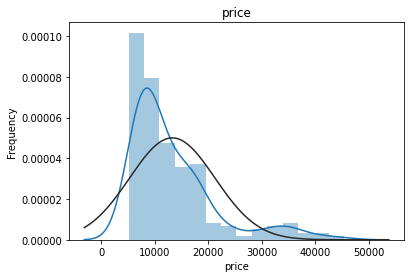

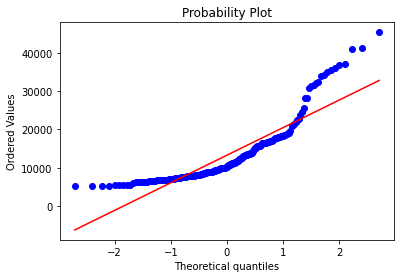

In [10]:
feat_plot(data, 'price')

We use the logarithm

In [11]:
data.price = np.log(data.price)

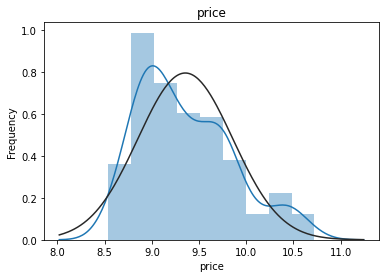

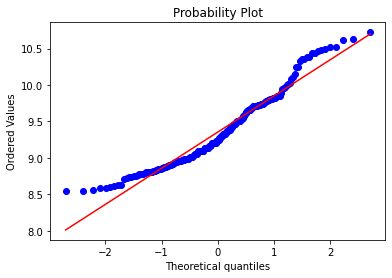

In [12]:
feat_plot(data, 'price')

 + let's shorten the `Carname` attribute to the car brand

In [13]:
data.CarName.unique()[:35]

array(['alfa-romero giulia', 'alfa-romero stelvio',
       'alfa-romero Quadrifoglio', 'audi 100 ls', 'audi 100ls',
       'audi fox', 'audi 5000', 'audi 4000', 'audi 5000s (diesel)',
       'bmw 320i', 'bmw x1', 'bmw x3', 'bmw z4', 'bmw x4', 'bmw x5',
       'chevrolet impala', 'chevrolet monte carlo', 'chevrolet vega 2300',
       'dodge rampage', 'dodge challenger se', 'dodge d200',
       'dodge monaco (sw)', 'dodge colt hardtop', 'dodge colt (sw)',
       'dodge coronet custom', 'dodge dart custom',
       'dodge coronet custom (sw)', 'honda civic', 'honda civic cvcc',
       'honda accord cvcc', 'honda accord lx', 'honda civic 1500 gl',
       'honda accord', 'honda civic 1300', 'honda prelude'], dtype=object)

In [14]:
for i in range(len(data.CarName)):
    data.CarName[i] = data.CarName[i].split(' ')[0]

In [15]:
data.CarName.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

 + delete `car_ID`, does not give information

In [16]:
data.drop('car_ID', axis=1, inplace=True)

+ remove 0 from the `symboling` attribute

In [17]:
data.symboling.unique()

array([ 3,  1,  2,  0, -1, -2])

In [18]:
data.symboling = data.symboling + 3

In [19]:
data.symboling.unique()

array([6, 4, 5, 3, 2, 1])

+ let's see how the other numeric variables are distributed - `num`

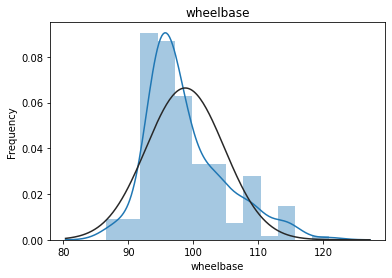

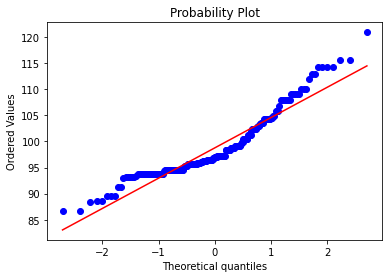

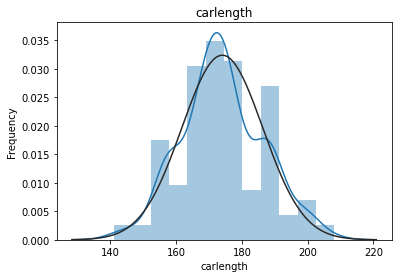

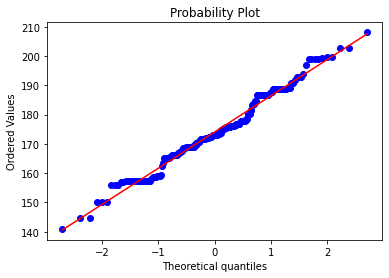

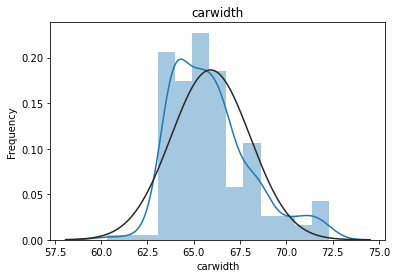

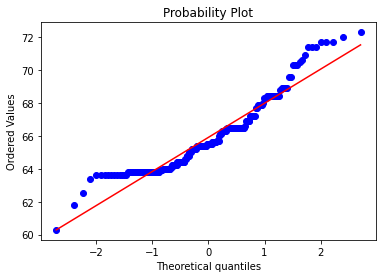

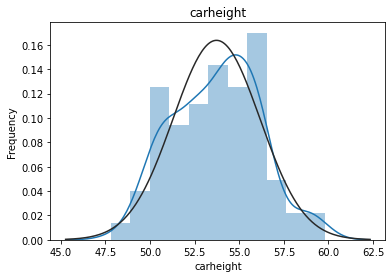

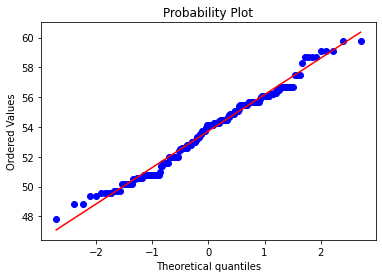

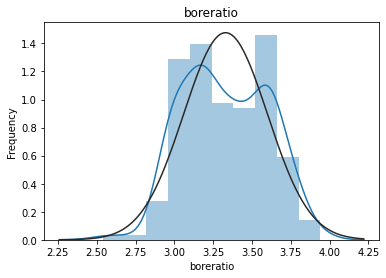

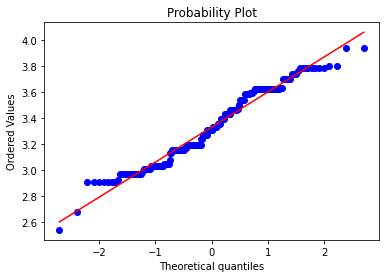

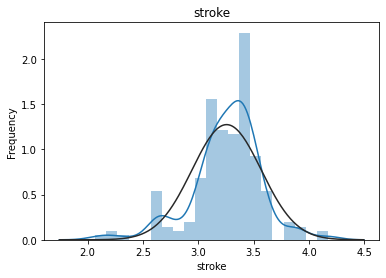

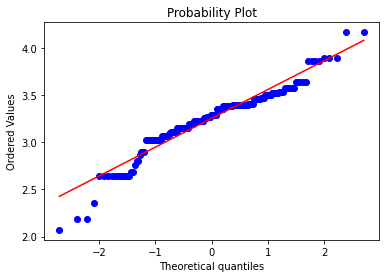

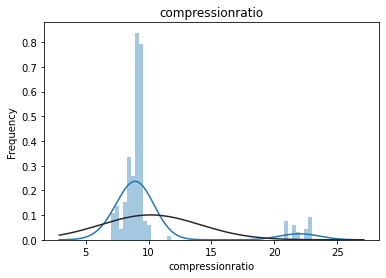

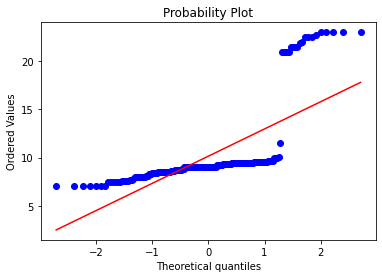

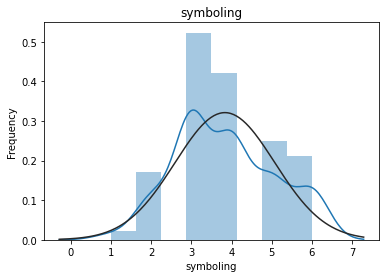

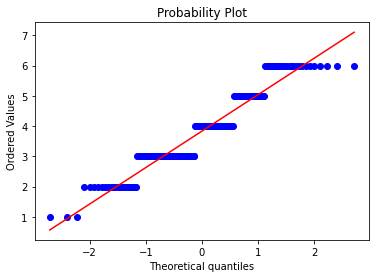

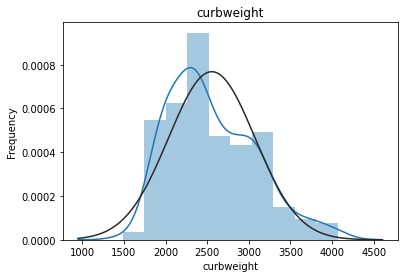

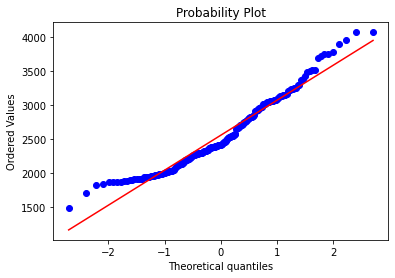

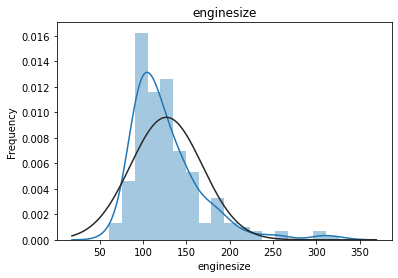

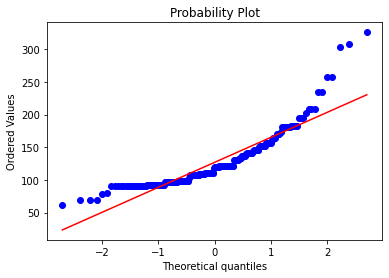

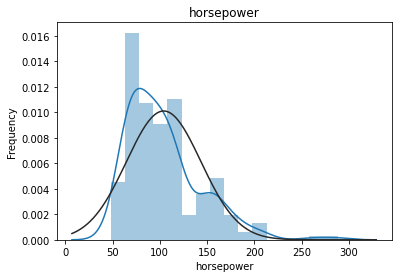

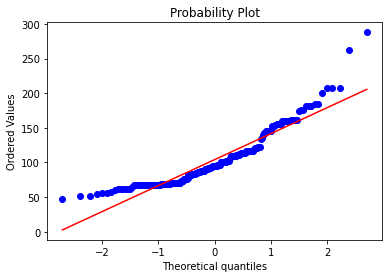

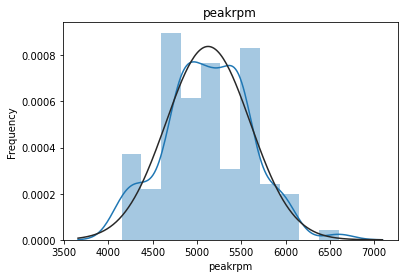

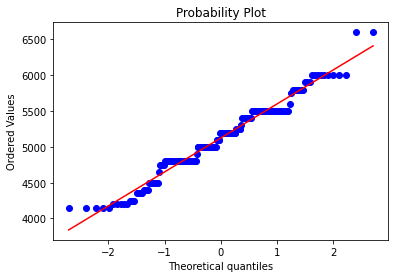

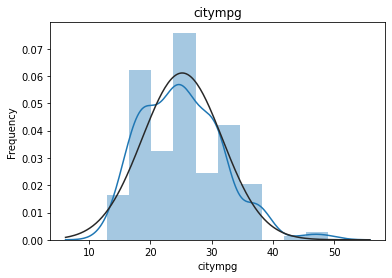

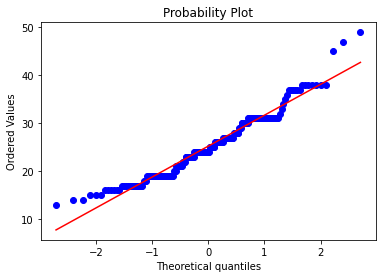

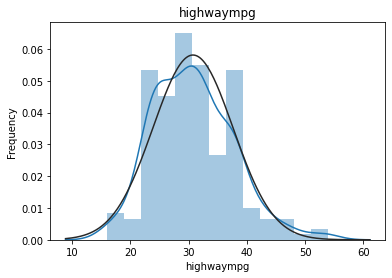

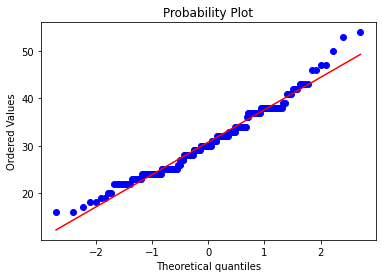

In [20]:
for i in num:
    feat_plot(data, i)

+ let's look at the distribution of the asymmetry coefficient, apply the `Box-Cox` transformation to the most asymmetric ones - from 0.75.

In [21]:
skewed_feats = data[num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
compressionratio,2.591720
enginesize,1.933375
horsepower,1.395006
wheelbase,1.042514
carwidth,0.897375
curbweight,0.676402
citympg,0.658838
highwaympg,0.536038
symboling,0.209525
carlength,0.154810


In [22]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.3
for feat in skewed_features:
    data[feat] = boxcox(data[feat], lam)

There are 14 skewed numerical features to Box Cox transform


+ processing of other veriblies   - `cat_features`

In [23]:
data[cat_features].head(3)

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi


They cannot be assigned a number, so we will split each value into a separate column

In [24]:
data = pd.get_dummies(data, columns=cat_features)

# Split and Scaler

Split the data into train and test, and scale all numeric variables - `num`

In [25]:
X = data.drop(['price'], axis=1)
y = data['price']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Before:

In [26]:
x_train[num].head(3)

,wheelbase,carlength,carwidth,carheight,boreratio,stroke,compressionratio,symboling,curbweight,enginesize,horsepower,peakrpm,citympg,highwaympg
177,10.031660,12.378834,8.408211,7.691077,1.440059,1.537236,3.045401,0.770481,31.344608,10.752635,9.609075,37.390958,5.626251,6.094757
75,10.043394,12.453579,8.487046,7.745982,1.634034,1.356151,2.886887,1.719055,33.145979,11.346366,12.362709,39.577776,4.729818,5.315193
174,10.031660,12.378834,8.408211,7.752043,1.422680,1.457292,5.149355,0.770481,31.437432,10.321819,8.741346,38.242647,5.913970,6.182195


In [27]:
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train[num])
x_test_sc = scaler.transform(x_test[num])

x_train[num] = x_train_sc
x_test[num] = x_test_sc

After:

In [28]:
x_train[num].head(3)

,wheelbase,carlength,carwidth,carheight,boreratio,stroke,compressionratio,symboling,curbweight,enginesize,horsepower,peakrpm,citympg,highwaympg
177,0.598269,0.101136,0.248457,0.059845,-0.010191,0.897762,-0.351725,-1.648902,-0.161475,-0.036552,-0.269884,-2.070790,0.440641,0.333718
75,0.647517,0.325836,0.936616,0.420715,1.641040,-0.406339,-0.625295,0.232617,0.706050,0.452430,1.706639,-0.287939,-0.990941,-1.014537
174,0.598269,0.101136,0.248457,0.460554,-0.158132,0.322035,3.279362,-1.648902,-0.116772,-0.391361,-0.892729,-1.376432,0.900122,0.484942


# Training the model

We run the models through a function with the specified algorithms, we take the R2 estimate as the criterion. In parallel, we do cross-validation on `train`, do it 20 times (`n_folds = 20`) and shuffle the data each time (`shuffle=True`).

In [29]:
def train_model(x_train, x_test, y_train, y_test):
    models = []
    n_folds = 20

    models.append(('R', Ridge(random_state=42)))
    models.append(('BR', BayesianRidge(n_iter=1000)))
    models.append(('KNR', KNeighborsRegressor()))
    models.append(('DTR', DecisionTreeRegressor(random_state=42)))
    models.append(('SVR', SVR()))
    models.append(('ABR', AdaBoostRegressor(n_estimators=300, random_state=42)))
    models.append(('BR', BaggingRegressor(n_estimators=300, random_state=42)))
    models.append(('ETR', ExtraTreesRegressor(n_estimators=300, random_state=42)))
    models.append(('GBR', GradientBoostingRegressor(n_estimators=300, random_state=42)))
    models.append(('XGB', XGBRegressor(n_estimators=300, random_state=42)))
    models.append(('RFR', RandomForestRegressor(n_estimators=300, random_state=42)))

    for name, model in models:

        kf = KFold(n_folds, shuffle=True, random_state=42)
        cv_results = cross_val_score(model, x_train, y_train, cv=kf, scoring='r2')

        model = model.fit(x_train, y_train)
        m_predict = model.predict(x_test)
        m_score = r2_score(np.exp(y_test), np.exp(m_predict))
        print("%s: r2_test = %.3f /// r2_train = %.3f" % (name, m_score, cv_results.mean()))

In [30]:
train_model(x_train, x_test, y_train, y_test)

R: r2_test = 0.938 /// r2_train = 0.853
BR: r2_test = 0.933 /// r2_train = 0.849
KNR: r2_test = 0.680 /// r2_train = 0.746
DTR: r2_test = 0.903 /// r2_train = 0.773
SVR: r2_test = 0.894 /// r2_train = 0.836
ABR: r2_test = 0.905 /// r2_train = 0.858
BR: r2_test = 0.942 /// r2_train = 0.863
ETR: r2_test = 0.909 /// r2_train = 0.851
GBR: r2_test = 0.917 /// r2_train = 0.862
XGB: r2_test = 0.905 /// r2_train = 0.842
RFR: r2_test = 0.942 /// r2_train = 0.862


The best result of BaggingRegressor and RandomForestRegressor is 0.942.